# Recommendation System

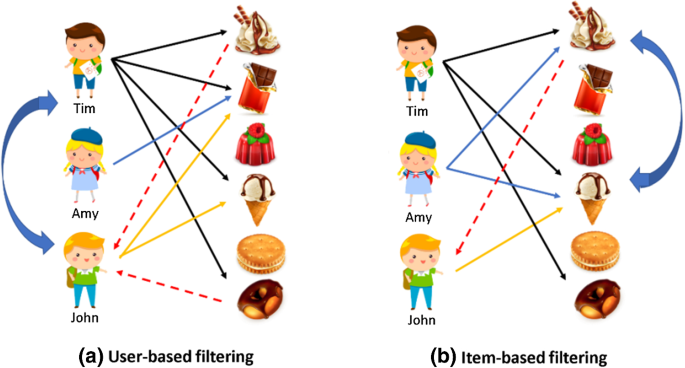

Recommendation system is one of the most common and effective service that many big players like Google, Netflix, and Amazon uses. <br>
The system allows the company to make assumption on one's preference of an item or a service not only from his or her previous records but also from various other factors. <br> <br>
Here, we will dispaly various ways to achieve recommendation: <br>
- Collaborative Filtering
- Model-based
- Hybrid Approach (CF + Model)

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf

In [3]:
import sys
import time
import json
import xgboost as xgb
import pandas as pd

In [4]:
conf = SparkConf().setAppName("task2-1").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [5]:
train_folder = 'json'
train_file = 'yelp_train.csv' 
test_file = 'yelp_val_in.csv' 

## Item-based Collaborative Filtering

Item-based CF can help us solve many problems that user-based CF innately has. <br>
For instance, user-based CF do not scale well. <br>
In addition, computational complexity increases as user increases. <br> <br>
So, item-based CF focus on other items the user has rated. 

### Initial Data Format

The training data will have 3 columns: user id, business id, and rating. <br>
The testing data, however, will have 2 columns: user id and business id. <br>
This is because we are going to make a recommendation system to predict the rating for the test data. 

In [6]:
df_train = pd.read_csv(train_folder+'/yelp_train.csv')
df_train.head()

,user_id,business_id,stars
0,vxR_YV0atFxIxfOnF9uHjQ,gTw6PENNGl68ZPUpYWP50A,5.0
1,o0p-iTC5yTBV5Yab_7es4g,iAuOpYDfOTuzQ6OPpEiGwA,4.0
2,-qj9ouN0bzMXz1vfEslG-A,5j7BnXXvlS69uLVHrY9Upw,2.0
3,E43QxgV87Ij6KxMCHcijKw,jUYp798M93Mpcjys_TTgsQ,5.0
4,T13IBpJITI32a1k41rc-tg,3MntE_HWbNNoyiLGxywjYA,5.0


In [7]:
df_test = pd.read_csv(test_file)
df_test.head()

,user_id,business_id,stars
0,wf1GqnKQuvH-V3QN80UOOQ,fThrN4tfupIGetkrz18JOg,NaN
1,39FT2Ui8KUXwmUt6hnwy-g,uW6UHfONAmm8QttPkbMewQ,NaN
2,7weuSPSSqYLUFga6IYP4pg,IhNASEZ3XnBHmuuVnWdIwA,NaN
3,CqaIzLiWaa-lMFYBAsYQxw,G859H6xfAmVLxbzQgipuoA,NaN
4,yy7shAsNWRbGg-8Y67Dzag,rS39YnrhoXmPqHLzCBjeqw,NaN


### Data Reformat (i)

The train data will be reformatted to list with 3 elements: user id, business id, and rating. <br> <br>
The test data for CF will require information of other users. <br>
Therefore, the format will be a list with each element being a tuple:
- First element of the tuple: business id
- Second element of the tuple: list of user ids that have rated the business 

The test data for model will be formatted to a list with 2 elements: user id and business id.

In [8]:
train_data = sc.textFile(train_folder+'/yelp_train.csv').filter(lambda x: x != 'user_id,business_id,stars').map(lambda x: x.split(",")).persist()
test_data_cf = sc.textFile(test_file).filter(lambda x: x != 'user_id,business_id,stars').map(lambda x: x.split(",")).map(lambda x: (x[1],x[0])).groupByKey().mapValues(list)
test_data_model = sc.textFile(test_file).filter(lambda x: x != 'user_id,business_id,stars').map(lambda x: x.split(",")).persist()

In [9]:
train_data.take(5)

[['vxR_YV0atFxIxfOnF9uHjQ', 'gTw6PENNGl68ZPUpYWP50A', '5.0'],
 ['o0p-iTC5yTBV5Yab_7es4g', 'iAuOpYDfOTuzQ6OPpEiGwA', '4.0'],
 ['-qj9ouN0bzMXz1vfEslG-A', '5j7BnXXvlS69uLVHrY9Upw', '2.0'],
 ['E43QxgV87Ij6KxMCHcijKw', 'jUYp798M93Mpcjys_TTgsQ', '5.0'],
 ['T13IBpJITI32a1k41rc-tg', '3MntE_HWbNNoyiLGxywjYA', '5.0']]

In [10]:
test_data_cf.take(5)[0]

('fThrN4tfupIGetkrz18JOg',
 ['wf1GqnKQuvH-V3QN80UOOQ',
  'EtxsD-Jbyxh7TsaWHtGCew',
  '09jpZrKD_j0SG9WPBDSJQg'])

In [11]:
test_data_model.take(5)

[['wf1GqnKQuvH-V3QN80UOOQ', 'fThrN4tfupIGetkrz18JOg'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'uW6UHfONAmm8QttPkbMewQ'],
 ['7weuSPSSqYLUFga6IYP4pg', 'IhNASEZ3XnBHmuuVnWdIwA'],
 ['CqaIzLiWaa-lMFYBAsYQxw', 'G859H6xfAmVLxbzQgipuoA'],
 ['yy7shAsNWRbGg-8Y67Dzag', 'rS39YnrhoXmPqHLzCBjeqw']]

### Data Reformat (ii)
To perform item-based CF, we will need several of the following:
* Because there may be cases where the pearson correlation coefficient is not computable or even 0.
1. Global average rating
2. Dictionary of user's average rating
3. Dictionary of business's average rating

* To perform Item-based CF
1. Dictionary with key: user id / value: list of business id the user has rated.
2. Dictionary with key: business id / value: list of users the business has been rated by.



In [12]:
user_average_dict = train_data.map(lambda x: (x[0],float(x[2]))).groupByKey().map(lambda x: (x[0],(sum(x[1])/len(x[1])))).collectAsMap()
business_average_dict = train_data.map(lambda x: (x[1],float(x[2]))).groupByKey().map(lambda x: (x[0],(sum(x[1])/len(x[1])))).collectAsMap()
default_rating = train_data.map(lambda x: (1,float(x[2]))).groupByKey().map(lambda x: (x[0],(sum(x[1])/len(x[1])))).values().collect()[0]

In [13]:
user_average_dict['o0p-iTC5yTBV5Yab_7es4g']

4.142857142857143

In [14]:
business_average_dict['3MntE_HWbNNoyiLGxywjYA']

3.4

In [15]:
default_rating

3.7511703308515445

In [16]:
user_list = train_data.map(lambda x: x[0]).distinct().collect()
business_list = train_data.map(lambda x: x[1]).distinct().collect()

In [17]:
user_dict = train_data.map(lambda x: (x[0],x[1])).groupByKey().mapValues(list).collectAsMap()
business_rating = train_data.map(lambda x: (x[1],[x[0],float(x[2])])).groupByKey().sortByKey().mapValues(dict).collectAsMap()

In [18]:
user_dict['o0p-iTC5yTBV5Yab_7es4g']

['iAuOpYDfOTuzQ6OPpEiGwA',
 'e_Nf4zAA1KZq80aoy3v8Ng',
 'qFZ7ReYNpjHuvSxOqXqHMg',
 'LwNZ1AR4_5iukgQYuhmTOg',
 'ZWcXoh_RO7rT2DdcyOzyfQ',
 'BORPULADzZV6_LJZzcsywQ',
 '3cHL1r5w2oLYH-veijtweA',
 'XXW_OFaYQkkGOGniujZFHg',
 'G0EJjh-dqJBmSEhQRog-hQ',
 'lfXfxBms5z1nwzkxxLFBWg',
 'i60v66vwf1A13YqcIqGD_A',
 'A37JfEzlKQygyzA-5p2dWw',
 'nVAJZ6BJ9PPlxDXn976R6A',
 'v3AS5LGeV2Si4nOHZ7lgxQ',
 'FaHADZARwnY4yvlvpnsfGA',
 'fQt9QVAZM9PM0wFDdROvWw',
 'pzUm_jLzVa9JAf4sC6tPLg',
 'mLjDh0vQYBCY6g9T1HczVw',
 'meXjqyhTNLFmknY39y2sMg',
 'ZwKUXfZguhBD1zsfb0RLPg',
 'SLJX2dksO_BeNMQUe3Nr8Q']

In [19]:
business_rating['3MntE_HWbNNoyiLGxywjYA']

{'T13IBpJITI32a1k41rc-tg': 5.0,
 'xhlcoVm3FOKcxZ0phkdO6Q': 4.0,
 '4o0KkpAkyO6r0NHXmobTeQ': 2.0,
 'TQXtrSpsUyvHMriX8hvNWQ': 2.0,
 'kjaUSiRWhR9bF9KxOMbVvg': 4.0}

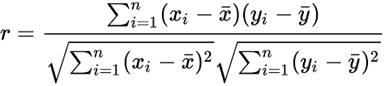

#### def weight_calculator(business,user): 

This function performs the pearson correlation coefficient calculation. <br>
* Will call the business we desire to find the rating of as STAR
1. The function first searches all the businesses an user has rated.
2. For each of those businesses, we check how other users have rated the business only under a situation where those users have also rated the STAR.
3. Using the above equation, we calculate the weight of each of those businesses. (The weight determines how impactful the rating of the user's other business will have in predicting the rating of the STAR.)

* There are some exception scenario where the denominator may end up being 0 (when the user has only rated one item, thus resulting in the rating and average rating becoming the same value.)

In [20]:
def weight_calculator(business,user):
    b_s = user_dict[user]
    b_s_count = len(b_s)
    a_avg = business_average_dict[business]
    a_dict = business_rating[business] 
    
    zero_count = 0
    weight_list = []
    weight_sum = 0
    for b in b_s:
        b_avg = business_average_dict[b]
        b_dict = business_rating[b]
        common_item = set(a_dict.keys()).intersection(set(b_dict.keys()))
        common_length = len(common_item)
        
        if common_length == 0:
            weight_list.append([0,0,b])
            zero_count+=1
            
        else:
            num = 0
            denom_1 = 0
            denom_2 = 0
            for item in common_item:
                num += (a_dict[item] - a_avg) * (b_dict[item] - b_avg)
                denom_1 += (a_dict[item] - a_avg)**2
                denom_2 += (b_dict[item] - b_avg)**2

            denom = (denom_1**(1/2)) * (denom_2**(1/2))
            if common_length < 50:
                zero_count+=1
                weight_list.append([0,common_length,b])
                        
            else:
                if num == 0 or denom_1 == 0 or denom_2 == 0:
                    zero_count += 1
                    weight_list.append([0,common_length,b])
                else:
                    weight = num / denom
                    if weight > 0:
                        weight_list.append([weight,common_length,b])
                        weight_sum+= weight
                    else:
                        zero_count+=1
                        weight_list.append([0,common_length,b])
                        
    weight_avg = 0
    if zero_count != b_s_count:
        weight_avg = weight_sum / (b_s_count - zero_count)
    else:
        weight_avg = 0
        
    for i in weight_list:
        if i[0] == 0:
            i[0] = weight_avg
            
    return weight_list

#### def pearson_coefficient_calculator(business,user):
This function utilizes the existing ratings and weights allocated for each business and will return the final rating of the STAR.

In [21]:
def pearson_coefficient_calculator(business,user):
    weight_list = weight_calculator(business,user)
    zero_count = 0
    for i in weight_list:
        if i[0] == 0:
            zero_count+=1
    
    if zero_count != len(weight_list):
        numerator = 0
        denominator = 0 
        for weight in weight_list:
            w = weight[0]
            #b = weight[1]
            u = weight[1]
            b = weight[2]
            numerator += business_rating[b][user] * w * u
            denominator += abs(w * u)

        if numerator == 0 or denominator == 0:
            return float((business_average_dict[business] + user_average_dict[user])/2)
        else:
            return numerator/denominator
    
    else:
        return float((business_average_dict[business] + user_average_dict[user])/2)

#### def item_based_cf(business,users):
Finally, when the calculation can be performed, we will calculate the final rating for the STAR. <br>
However, if the STAR is a completely new business with no rating from other users, or the user has not rated any other businesses, we will utilize average scores to make a simple prediction of the STAR.

In [22]:
def item_based_cf(business,users):
    rating_list = []
    if business not in business_list:
        for user in users:
            if user not in user_list:
                rating_list.append([user,default_rating])
            
            else:
                rating_list.append([user,user_average_dict[user]])

    else:
        for user in users:
            if user not in user_list:
                rating_list.append([user,business_average_dict[user]])
            
            else:
                rating_list.append([user,pearson_coefficient_calculator(business,user)])    
                
    return business,rating_list

### Metric

Our metric to determine how well our recommendation system is performing will be RMSE. 

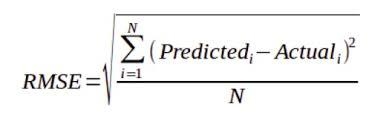

In [23]:
def rmse(real_list, pred_list):
    n = len(real_list)
    temp = 0
    for i in range(0,n,1):
        temp+= (float(real_list[i][2]) - float(pred_list[i][2]))**2
    return (temp/n)**(1/2)
        

In [24]:
def reformat(a_list):
    last_list = []
    business = a_list[0]
    for i in a_list[1]:
        last_list.append([i[0],business,i[1]])
        
    return last_list

In [26]:
start = time.time()
prediction = test_data_cf.map(lambda x: item_based_cf(x[0],x[1])).flatMap(lambda x: reformat(x)).collect()
end = time.time()
print(str(end-start))

56.52596139907837


In [27]:
validation_data = sc.textFile('yelp_val.csv').filter(lambda x: x != 'user_id,business_id,stars').map(lambda x: x.split(",")).collect()
validation_data.sort()

## Conclusion for Item-based CF

Our resulting RMSE was 1.0194570283662283. <br>
I have displayed some rows as an example. <br>
- Validation data shows the true rating.
- Prediction data shows our prediction.

There are definitely room for improvements. <br>
Obviously Item-based CF is not perfect as you can see by the 2nd row. <br>
So, we will see how we can improve it by using a Model.

In [28]:
prediction.sort()
a = rmse(validation_data,prediction)
print(a)

1.0194570283662283


In [29]:
validation_data[0:10]

[['---1lKK3aKOuomHnwAkAow', '-ErwgUmZ1-jHW_rSu55jlg', '5.0'],
 ['---1lKK3aKOuomHnwAkAow', '1JgaRBX0oiRsvEhHF3ZMjw', '1.0'],
 ['---1lKK3aKOuomHnwAkAow', 'DXlDzOcpdUE_F21tok0fgw', '4.0'],
 ['---1lKK3aKOuomHnwAkAow', 'Ks0M3J4vZAKsHPuCINz5fQ', '4.0'],
 ['---1lKK3aKOuomHnwAkAow', 'N8Rwk4XrKaHYXXninuxg9Q', '5.0'],
 ['---1lKK3aKOuomHnwAkAow', 'RJtgNpUFthlJ5grLr16GxA', '5.0'],
 ['---1lKK3aKOuomHnwAkAow', 'TTpgjbrSyxwHHzE5bIF-Rw', '3.0'],
 ['---1lKK3aKOuomHnwAkAow', 'UutHMmZx1CQcjiyfmVa_7g', '5.0'],
 ['---1lKK3aKOuomHnwAkAow', 'Xspg78dOvuedvuPEUwZBjw', '4.0'],
 ['---1lKK3aKOuomHnwAkAow', 'YCEZLECK9IToE8Mysorbhw', '5.0']]

In [30]:
prediction[0:10]

[['---1lKK3aKOuomHnwAkAow', '-ErwgUmZ1-jHW_rSu55jlg', 3.702991452991453],
 ['---1lKK3aKOuomHnwAkAow', '1JgaRBX0oiRsvEhHF3ZMjw', 3.668269230769231],
 ['---1lKK3aKOuomHnwAkAow', 'DXlDzOcpdUE_F21tok0fgw', 4.087734404898584],
 ['---1lKK3aKOuomHnwAkAow', 'Ks0M3J4vZAKsHPuCINz5fQ', 3.7356711915535445],
 ['---1lKK3aKOuomHnwAkAow', 'N8Rwk4XrKaHYXXninuxg9Q', 4.480769230769231],
 ['---1lKK3aKOuomHnwAkAow', 'RJtgNpUFthlJ5grLr16GxA', 3.855769230769231],
 ['---1lKK3aKOuomHnwAkAow', 'TTpgjbrSyxwHHzE5bIF-Rw', 4.001602564102564],
 ['---1lKK3aKOuomHnwAkAow', 'UutHMmZx1CQcjiyfmVa_7g', 3.9353146853146854],
 ['---1lKK3aKOuomHnwAkAow', 'Xspg78dOvuedvuPEUwZBjw', 3.9252136752136755],
 ['---1lKK3aKOuomHnwAkAow', 'YCEZLECK9IToE8Mysorbhw', 3.706959706959707]]

## Model Based
In previous section, we took a more mathematical approach. <br>
For model based, we will simplify. <br>
We will format our data to be apt for model's input.

### Data Reformat (iii)
We will use data that we have used in previous sections. <br>
However, for the model based, we will fully utilize other sources of data available. <br>
We will also use:
- number of review a user has made
- user's average rating
- number of review of the business
- business' average rating

In [31]:
user = sc.textFile(train_folder+'/user.json').map(lambda x: json.loads(x)).filter(lambda x : x['user_id'] in user_list)\
.map(lambda x : (x['user_id'], [x['review_count'], x['average_stars']])).collectAsMap()

business = sc.textFile(train_folder+'/business.json').map(lambda x: json.loads(x)).filter(lambda x : x['business_id'] in business_list)\
.map(lambda x : (x['business_id'], [x['review_count'], x['stars']])).collectAsMap()

In [33]:
user['Oqa4MoR-8xxKmQBIEdwT2g']

[91, 4.37]

In [35]:
business['tZnSodhPwNr4bzrwJ1CSbw']

[146, 4.0]

In [37]:
def get_average(a_list):
    temp_1 = 0
    temp_2 = 0
    count_1 = 0
    count_2 = 0
    for i in a_list:
        temp_1 += (i[0]*i[1])
        temp_2 += i[1]
        count_1 += i[1]
        count_2 += 1
    
    return temp_1/count_1, temp_2/count_2

In [38]:
user_avg_review_count, user_avg_rating = get_average(user.values())
business_avg_review_count, business_avg_rating = get_average(business.values())

In [39]:
def x_test_generator(entry):
    u = entry[0]
    b = entry[1]
    case = [1,1]
    if u not in user_list:
        case[0] = 0
    if b not in business_list:
        case[1] = 0
    
    #print(case)
    if case[0] == 0 and case[1] == 1:
        return [user_avg_reivew_count, user_avg_rating, business[b][0], business[b][1]]
    
    elif case[0] == 1 and case[1] == 0:
        return [user[u][0], user[u][1], business_avg_review_count, business_avg_rating]
    
    elif case[0] == 0 and case[1] == 0:
        return [user_avg_review_count, user_avg_rating, business_avg_review_count, business_avg_rating]
    
    else:
        return [user[u][0],user[u][1], business[b][0],business[b][1]]

In [40]:
x_train = train_data.map(lambda x: [user[x[0]][0],user[x[0]][1], business[x[1]][0],business[x[1]][1]]).collect()
y_train = train_data.map(lambda x: float(x[2])).collect()
x_test_label = test_data_model.collect()
x_test = test_data_model.map(lambda x: x_test_generator(x)).collect()

In [41]:
model = xgb.XGBRegressor(learning_rate=0.2)
model = model.fit(x_train, y_train)
y_test = model.predict(x_test)

In [42]:
final_list = []
for i in range(0,142044,1):
    temp = []
    temp.extend(x_test_label[i])
    temp.append(y_test[i])
    final_list.append(temp)
final_list.sort()

In [43]:
b = rmse(validation_data, final_list)
print(b)

0.9844072260209719


## Conclusion for Model-based Recommendation System
For the model-based, we achieved a RMSE of 0.9844072260209719, which is a bette result than that of Item-based. <br>
Unlike Item-based CF, we had to further dig the data and arrange it to an adapatable form for our model (XGBRegressor). <br>
So, we can say the data preparation step can become more difficult, but achiving a prediction became easier and more efficient. <br> <br>
Obviously, there are lots of space for improvement here as well. 
- Add more input for the model
- Check the redundancy of the data to eliminiate unnecessary input.